# Initialize and cleaning of play-by-play data

## Load the data

In [1]:
#Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib as mpl
from scipy.interpolate import make_interp_spline, BSpline
from adjustText import adjust_text

%config InlineBackend.figure_format = 'retina'

In [2]:
#hardcode colors
colors = {
    'ARI':'#97233F',
    'ATL':'#A71930',
    'BAL':'#241773',
    'BUF':'#00338D',
    'CAR':'#0085CA',
    'CHI':'#C83803',
    'CIN':'#FB4F14',
    'CLE':'#311D00',
    'DAL':'#041E42',
    'DEN':'#FB4F14',
    'DET':'#0076B6',
    'GB' :'#203731',
    'HOU':'#03202F',
    'IND':'#002C5F',
    'JAX':'#006778',
    'KC' :'#E31837',
    'LAC':'#0080C6',
    'LAR':'#866D4B',
    'MIA':'#008E97',
    'MIN':'#4F2683',
    'NE' :'#002244',
    'NO' :'#D3BC8D',
    'NYG':'#0B2265',
    'NYJ':'#125740',
    'OAK':'#A5ACAF',
    'PHI':'#004C54',
    'PIT':'#FFB612',
    'SEA':'#69BE28',
    'SF' :'#AA0000',
    'TB' :'#D50A0A',
    'TEN':'#0C2340',
    'WAS':'#773141'
}

kc_p = '#E31837'
kc_s = '#FFB81C'

In [3]:
#load data
data = pd.read_csv('clean_pbp_2019_wk19.csv')

C:\Users\Ethan Douglas\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (42,167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,199,200,204,205,206,219,220,221,222,223,224,227,228,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Analysis

In [4]:
#some minor feature engineering
data.loc[data['interception']==1, 'complete_pass'] = 0
data['cpoe'] = data['complete_pass'] - data['cp']

In [5]:
#Fixing old team naming conventions
data.loc[(data['posteam']=='LA'),'posteam'] = 'LAR'
data.loc[(data['posteam']=='SD'),'posteam'] = 'LAC'
data.loc[(data['posteam']=='JAC'),'posteam'] = 'JAX'
data.loc[(data['posteam']=='STL'),'posteam'] = 'LAR'

In [7]:
#get all postseason dropbacks
postseason_passes = data.loc[(data['pass']==1) & (data['week']>=18)]
#Group by who throw the pass
qbs = postseason_passes.groupby(by=['name'])['epa','success','air_yards','cpoe','yards_after_catch'].mean()
#Get number of attempts, so we can filter out QBs who have only thrown a few passes
qbs['attempts'] = postseason_passes.groupby(by=['name'])['epa'].count()
qbs.reset_index(inplace=True)
qbs = qbs.loc[(qbs['attempts']>=100)]

In [10]:
qbs.sort_values(by=['epa'],ascending=False,inplace=True)
qbs

,name,epa,success,air_yards,cpoe,yards_after_catch,attempts
60,N.Foles,0.277044,0.513889,8.552885,0.058982,5.048951,216
62,P.Mahomes,0.250729,0.459016,9.495327,0.005955,6.818182,122
24,D.Brees,0.226070,0.540590,7.990329,0.054747,4.935211,542
54,M.Ryan,0.221843,0.500000,9.254181,0.064700,4.453202,328
17,C.Kaepernick,0.209184,0.491892,11.531250,0.016986,4.595745,185
5,A.Rodgers,0.200901,0.491279,9.500805,0.039082,4.482234,688
68,R.Wilson,0.193479,0.474409,10.603365,0.049254,5.034091,508
55,M.Sanchez,0.192115,0.450000,9.438710,-0.005147,5.319149,160
29,E.Manning,0.182449,0.470320,8.926471,0.007374,4.821705,219
71,T.Brady,0.180299,0.500000,8.247554,0.012628,5.131700,1072


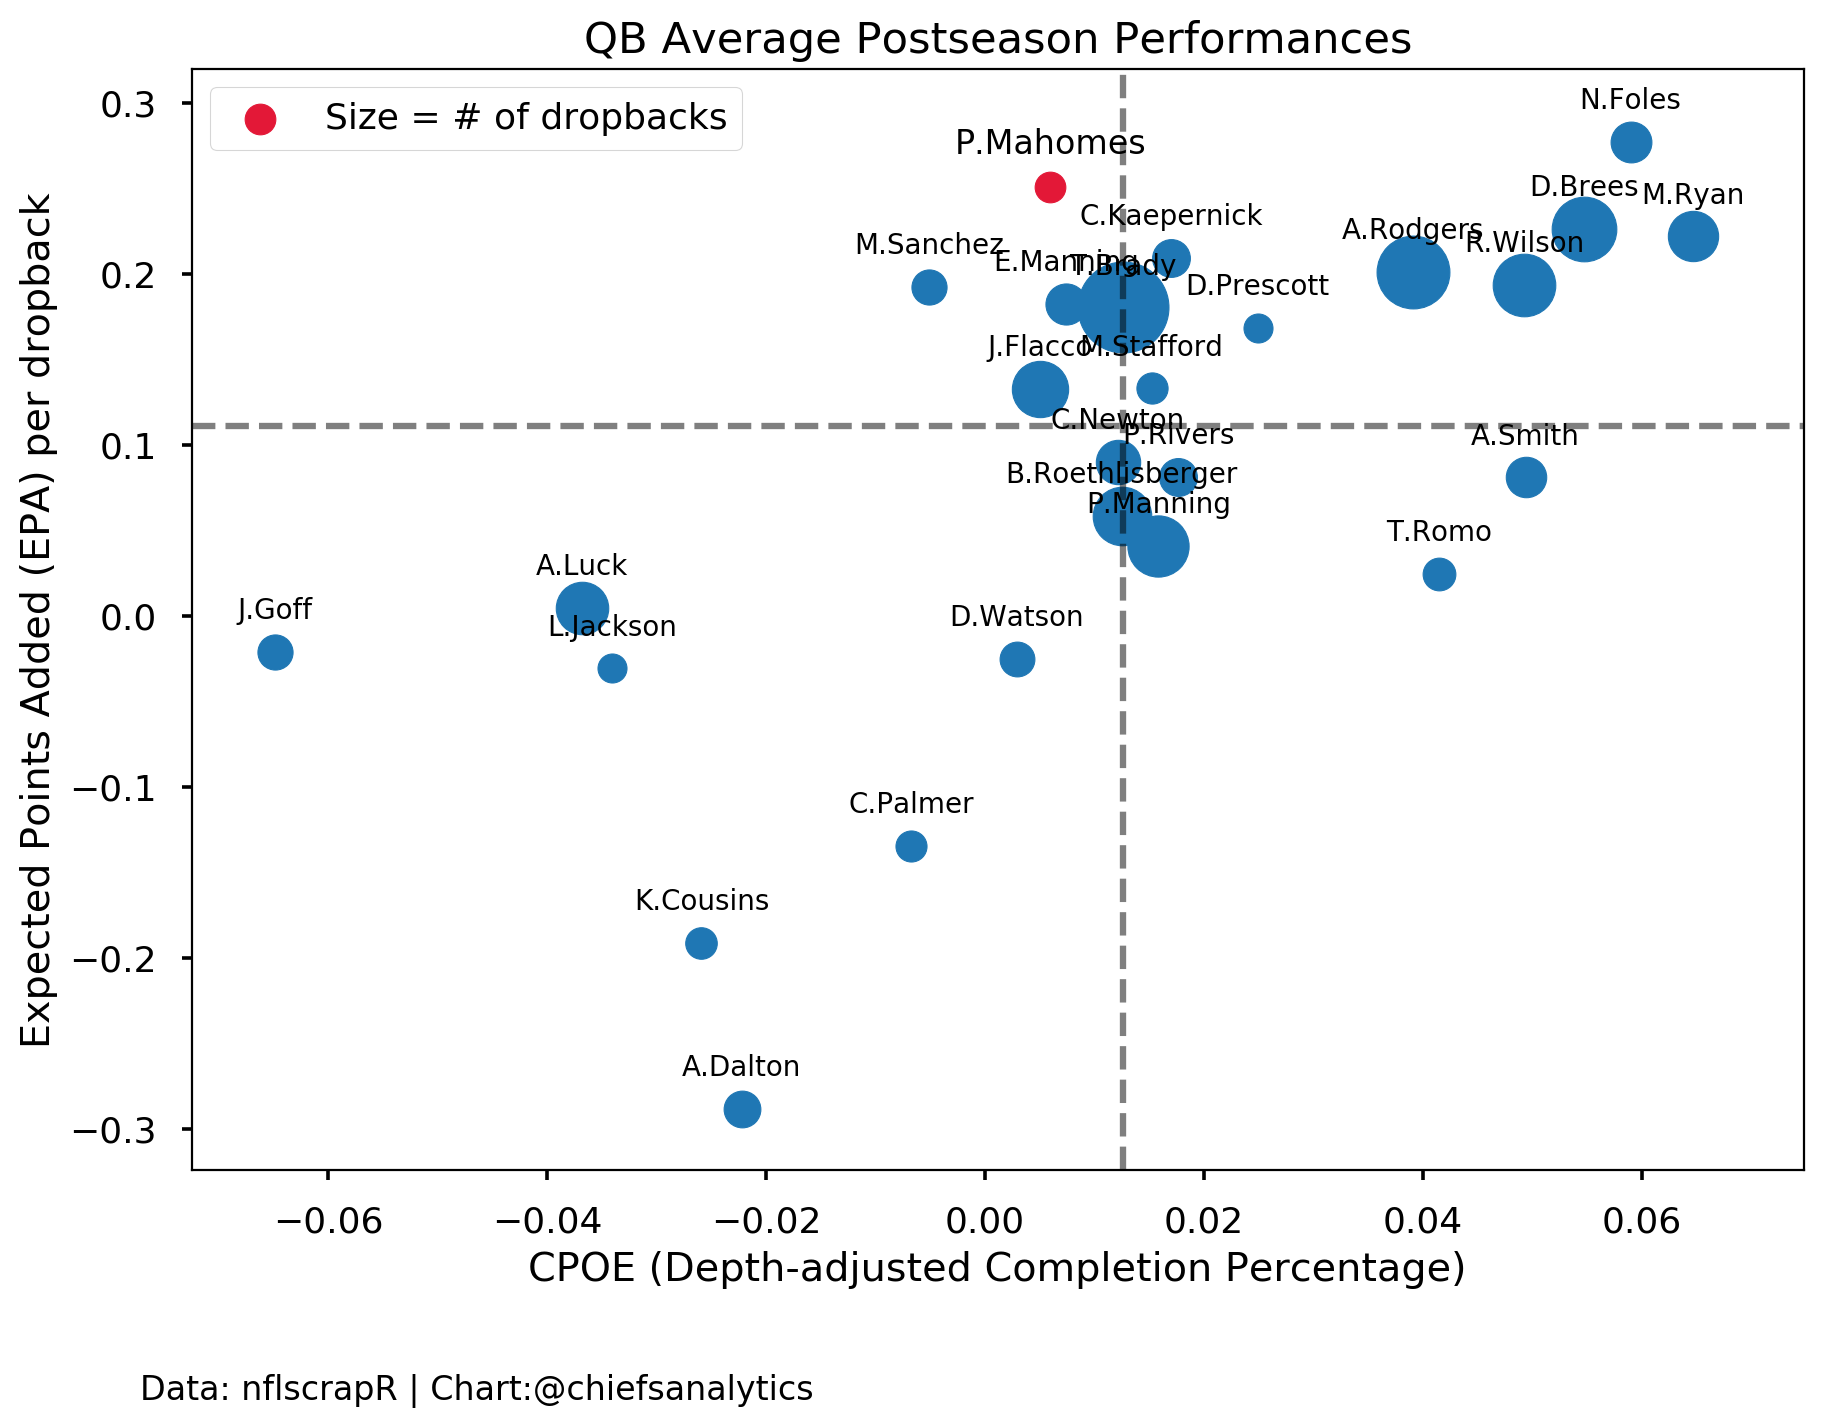

In [31]:
#Plotting
plt.style.use('default')
plt.style.use('seaborn-talk')
#Plot 50th% of our variables
plt.axvline(qbs['cpoe'].median(),ls='--',c='k',alpha=0.5)
plt.axhline(qbs['epa'].median(),ls='--',c='k',alpha=0.5)
#Going to do something different for Mahomes, so grabbing his row separately
mahomes = qbs.iloc[1]
#Loop to plot each QB - this isn't at all necessary, but i keep this structure for when I am doing team color plots
for index,qb in qbs.iterrows():
    if qb['name']=='P.Mahomes':
        continue
    plt.scatter(qb['cpoe'], qb['epa'], c='tab:blue', 
                s=qb['attempts']*1, alpha=1)
    plt.annotate(qb['name'], # this is the text
            (qb['cpoe'],qb['epa']), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(0,12), # distance from text to points (x,y)
            ha='center',fontsize = 10,
            alpha=1) # horizontal alignment can be left, right or center     
#Plot mahomes
plt.scatter(mahomes['cpoe'],mahomes['epa'], c=kc_p, s=mahomes['attempts']*1,label='Size = # of dropbacks')
plt.annotate('P.Mahomes',
            (mahomes['cpoe'],mahomes['epa']),
            textcoords="offset points", # how to position the text
                 xytext=(0,12), # distance from text to points (x,y)
                 ha='center',fontsize = 12)


#Title, labels
plt.title('QB Average Postseason Performances')
plt.ylabel('Expected Points Added (EPA) per dropback')
plt.xlabel('CPOE (Depth-adjusted Completion Percentage)')
txt = "Data: nflscrapR | Chart:@chiefsanalytics"
plt.figtext(0.1, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=12)
plt.legend(loc='upper left')